### Supervised Learning Models
# Support Vector Machine

In [2]:
"""
SVM Hyperparameters:

1. C (Regularization)
Controls: Trade-off between margin size and misclassification
    Low C (e.g., 0.1):
    - Large margin, allows misclassification
    - Simple model, less overfitting
    - May underfit

    High C (e.g., 100):
    - Small margin, minimizes misclassification
    - Complex model, may overfit
    - Tries hard to get all training points correct

2. Kernel
Controls: Shape of decision boundary
    kernel='linear':
    - Straight line decision boundary
    - Fast, simple
    - Use when: Data is roughly linear

    kernel='rbf':
    - Curved, flexible decision boundary
    - More powerful, handles non-linear patterns
    - Use when: Data has complex patterns

3. class_weight
Controls: How to handle class imbalance
    'balanced': Weight rare class more (for imbalance) 
    None: Treat classes equally

"""

"\nSVM Hyperparameters:\n\n1. C (Regularization)\nControls: Trade-off between margin size and misclassification\n    Low C (e.g., 0.1):\n    - Large margin, allows misclassification\n    - Simple model, less overfitting\n    - May underfit\n\n    High C (e.g., 100):\n    - Small margin, minimizes misclassification\n    - Complex model, may overfit\n    - Tries hard to get all training points correct\n\n2. Kernel\nControls: Shape of decision boundary\n    kernel='linear':\n    - Straight line decision boundary\n    - Fast, simple\n    - Use when: Data is roughly linear\n\n    kernel='rbf':\n    - Curved, flexible decision boundary\n    - More powerful, handles non-linear patterns\n    - Use when: Data has complex patterns\n\n3. class_weight\nControls: How to handle class imbalance\n    'balanced': Weight rare class more (for imbalance) \n    None: Treat classes equally\n\n"

In [3]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import seaborn as sns
from sklearn.model_selection import cross_validate, GridSearchCV, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report, roc_curve, auc)
import warnings
warnings.filterwarnings('ignore')



In [4]:
# Random seed for reproducability
np.random.seed(42)

In [5]:
# Load data
train_data = pd.read_csv('framingham_train_processed.csv')
test_data = pd.read_csv('framingham_test_processed.csv')

X_train = train_data.drop('TenYearCHD', axis=1)
y_train = train_data['TenYearCHD']

X_test = test_data.drop('TenYearCHD', axis=1)
y_test = test_data['TenYearCHD']

print(f"Training data: {X_train.shape}")
print(f"Test data: {X_test.shape}")
print()

Training data: (3390, 15)
Test data: (848, 15)



In [6]:
# Set up cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [7]:
# Define hyper parameter grid¨
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'class_weight': ['balanced', None]
}

print("Hyperparameter combinations to test:")
print(f"  C values: {param_grid_svm['C']}")
print(f"  kernel values: {param_grid_svm['kernel']}")
print(f"  class_weight values: {param_grid_svm['class_weight']}")
print()

num_combinations = len(param_grid_svm['C']) * len(param_grid_svm['kernel']) * len(param_grid_svm['class_weight'])
print(f"Total combinations: {num_combinations}")
print(f"With 5-fold CV: {num_combinations * 5} model trainings")
print()

Hyperparameter combinations to test:
  C values: [0.1, 1, 10, 100]
  kernel values: ['linear', 'rbf']
  class_weight values: ['balanced', None]

Total combinations: 16
With 5-fold CV: 80 model trainings



In [8]:
# Create base model
svm_base = SVC(probability=True, random_state=42)

In [9]:
# Run grid search

grid_search_svm = GridSearchCV(
    estimator=svm_base,
    param_grid=param_grid_svm,
    cv=cv,
    scoring='roc_auc',  # Optimize for ROC-AUC
    n_jobs=-1,  # Use all CPU cores
    verbose=1  # Print progress
)

# Fit the grid search
grid_search_svm.fit(X_train, y_train)

print()
print("Grid Search Complete!")
print()

Fitting 5 folds for each of 16 candidates, totalling 80 fits

Grid Search Complete!



In [10]:
# Best hyperparameters
print(f"Best parameters: {grid_search_svm.best_params_}")
print(f"Best cross-validation ROC-AUC score: {grid_search_svm.best_score_:.4f}")
print()

Best parameters: {'C': 0.1, 'class_weight': 'balanced', 'kernel': 'linear'}
Best cross-validation ROC-AUC score: 0.7326



In [11]:
# Get the best model
svm_model = grid_search_svm.best_estimator_

In [12]:
# Top 10 hyperparameter combinations

results_df = pd.DataFrame(grid_search_svm.cv_results_)
results_df = results_df[['param_C', 'param_kernel', 'param_class_weight', 'mean_test_score', 'std_test_score']]
results_df.columns = ['C', 'kernel', 'class_weight', 'Mean ROC-AUC', 'Std ROC-AUC']
results_df = results_df.sort_values('Mean ROC-AUC', ascending=False)

print(results_df.head(10))
print()


        C  kernel class_weight  Mean ROC-AUC  Std ROC-AUC
0     0.1  linear     balanced      0.732576     0.024727
4     1.0  linear     balanced      0.730759     0.024820
12  100.0  linear     balanced      0.730222     0.024766
8    10.0  linear     balanced      0.730212     0.024750
1     0.1     rbf     balanced      0.724062     0.023786
5     1.0     rbf     balanced      0.702696     0.023287
14  100.0  linear         None      0.676701     0.021877
7     1.0     rbf         None      0.631541     0.021900
9    10.0     rbf     balanced      0.631537     0.023289
3     0.1     rbf         None      0.630261     0.022057



In [13]:
# Saving the model
import pickle

with open('svm_model.pkl', 'wb') as f:
    pickle.dump(svm_model, f)

print("Model saved as 'svm_model.pkl'")
print()

Model saved as 'svm_model.pkl'



## Evaluating the model

In [14]:
# Define metrics for evaluation
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [15]:
# Perform cross-validation with all metrics
cv_results = cross_validate(
    svm_model, 
    X_train, 
    y_train, 
    cv=cv, 
    scoring=scoring,
    return_train_score=True
)


In [16]:
# Display cross validation scoring results
for metric in scoring.keys():
    train_scores = cv_results[f'train_{metric}']
    test_scores = cv_results[f'test_{metric}']
    
    print(f"{metric.upper()}:")
    print(f"  Training:  {train_scores.mean():.4f} (±{train_scores.std():.4f})")
    print(f"  CV Test:   {test_scores.mean():.4f} (±{test_scores.std():.4f})")
    print(f"  Individual folds: {[f'{score:.4f}' for score in test_scores]}")
    print()

ACCURACY:
  Training:  0.6606 (±0.0026)
  CV Test:   0.6608 (±0.0184)
  Individual folds: ['0.6593', '0.6416', '0.6401', '0.6858', '0.6770']

PRECISION:
  Training:  0.2687 (±0.0018)
  CV Test:   0.2676 (±0.0142)
  Individual folds: ['0.2714', '0.2500', '0.2526', '0.2868', '0.2769']

RECALL:
  Training:  0.7165 (±0.0062)
  CV Test:   0.7068 (±0.0198)
  Individual folds: ['0.7379', '0.6796', '0.6990', '0.7184', '0.6990']

F1:
  Training:  0.3908 (±0.0025)
  CV Test:   0.3880 (±0.0169)
  Individual folds: ['0.3969', '0.3655', '0.3711', '0.4100', '0.3967']

ROC_AUC:
  Training:  0.7413 (±0.0063)
  CV Test:   0.7326 (±0.0247)
  Individual folds: ['0.7534', '0.7184', '0.7010', '0.7686', '0.7215']



In [17]:
# Test set performance 
# Make predictions on test set
y_pred = svm_model.predict(X_test)
y_pred_proba = svm_model.predict_proba(X_test)[:, 1]  # Probability of class 1

print("Test Set Metrics:")

test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)
test_roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy:  {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall:    {test_recall:.4f}")
print(f"F1-Score:  {test_f1:.4f}")
print(f"ROC-AUC:   {test_roc_auc:.4f}")

Test Set Metrics:
Accuracy:  0.6439
Precision: 0.2387
Recall:    0.6124
F1-Score:  0.3435
ROC-AUC:   0.6999


In [18]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
print()

tn, fp, fn, tp = cm.ravel()

print("Interpretation:")
print(f"  True Negatives (TN):  {tn}")
print(f"  False Positives (FP): {fp}")
print(f"  False Negatives (FN): {fn}")
print(f"  True Positives (TP):  {tp}")

[[467 252]
 [ 50  79]]

Interpretation:
  True Negatives (TN):  467
  False Positives (FP): 252
  False Negatives (FN): 50
  True Positives (TP):  79


In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.65      0.76       719
           1       0.24      0.61      0.34       129

    accuracy                           0.64       848
   macro avg       0.57      0.63      0.55       848
weighted avg       0.80      0.64      0.69       848



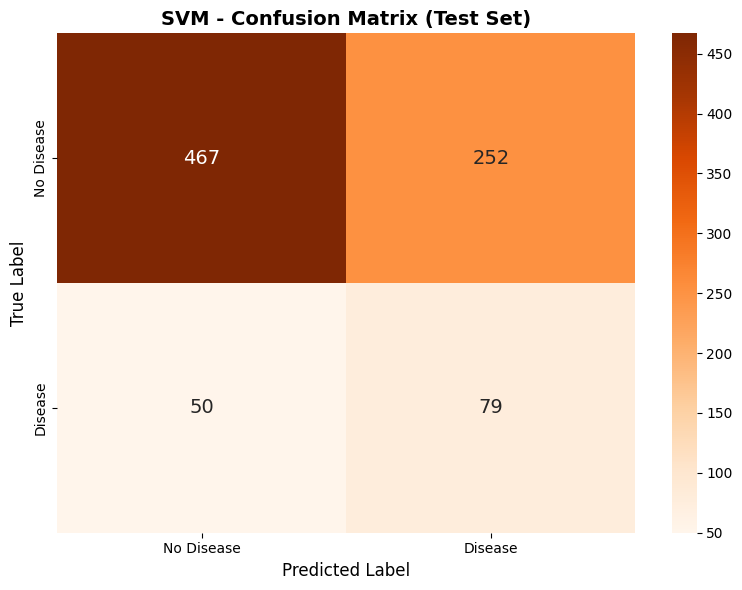

In [20]:
fig, ax = plt.subplots(figsize=(8, 6))

# Create heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'],
            cbar=True, ax=ax, annot_kws={'size': 14})

ax.set_title('SVM - Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12)
ax.set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.show()


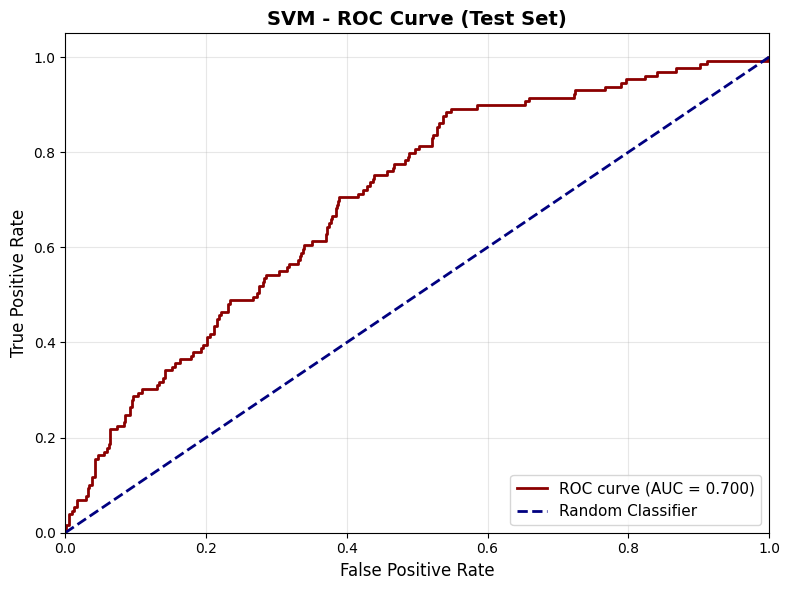

In [22]:
# ROC curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(fpr, tpr, color='darkred', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('SVM - ROC Curve (Test Set)', fontsize=14, fontweight='bold')
ax.legend(loc="lower right", fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

            Feature  Importance
0               age    0.015920
1        cigsPerDay    0.011557
7           glucose    0.005189
8              male    0.005189
9     currentSmoker    0.003656
5               BMI    0.002830
13         diabetes    0.002241
14        education    0.000354
11  prevalentStroke   -0.000118
10           BPMeds   -0.000943
4             diaBP   -0.001533
6         heartRate   -0.001769
3             sysBP   -0.002005
12     prevalentHyp   -0.006722
2           totChol   -0.010377


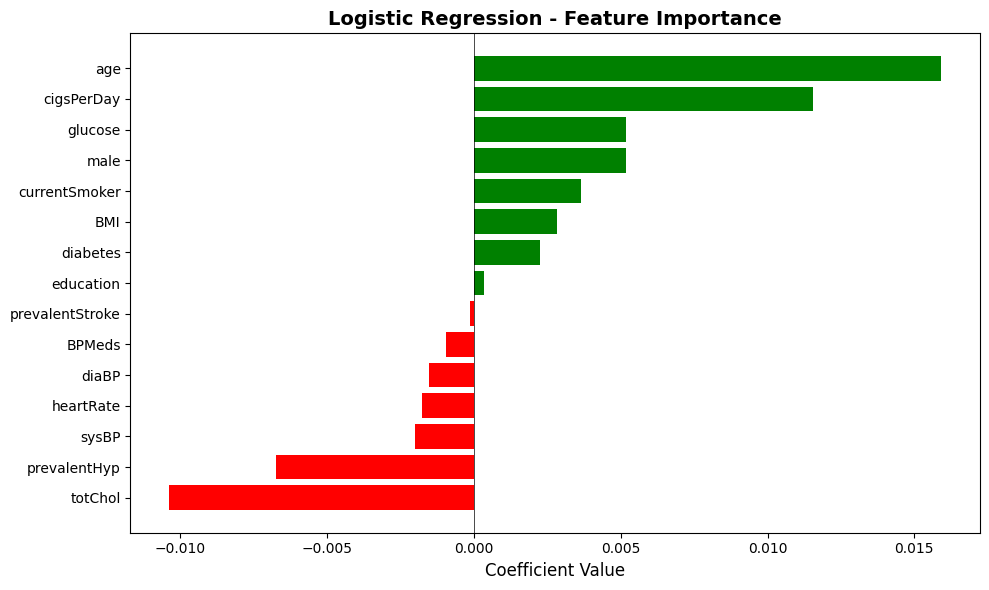

In [23]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(
    svm_model, X_test, y_test, 
    n_repeats=10, random_state=42, n_jobs=-1
)

feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': perm_importance.importances_mean
}).sort_values('Importance', ascending=False)

print(feature_importance)

# Visualize features
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['red' if x < 0 else 'green' for x in feature_importance['Importance']]

ax.barh(range(len(feature_importance)), feature_importance['Importance'].values, color=colors)
ax.set_yticks(range(len(feature_importance)))
ax.set_yticklabels(feature_importance['Feature'].values)
ax.set_xlabel('Coefficient Value', fontsize=12)
ax.set_title('Logistic Regression - Feature Importance', fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.invert_yaxis()

plt.tight_layout()
plt.show()

In [24]:
print("KEY FINDINGS:")
print()
print(f"  - CV Recall: {cv_results['test_recall'].mean():.1%}")
print(f"    (Catches {cv_results['test_recall'].mean():.1%} of disease cases)")
print()
print(f"  - Test ROC-AUC: {test_roc_auc:.4f}")
print(f"    (Good discrimination between classes)")
print()
print(f"  - Most important features: {', '.join(feature_importance.head(3)['Feature'].values)}")
print()

KEY FINDINGS:

  - CV Recall: 70.7%
    (Catches 70.7% of disease cases)

  - Test ROC-AUC: 0.6999
    (Good discrimination between classes)

  - Most important features: age, cigsPerDay, glucose



In [26]:
svm_results = {
    'model_name': 'SVM',
    'test_metrics': {
        'accuracy': test_accuracy,
        'precision': test_precision,
        'recall': test_recall,
        'f1': test_f1,
        'roc_auc': test_roc_auc
    },
    'cv_metrics': {
        'accuracy': (cv_results['test_accuracy'].mean(), cv_results['test_accuracy'].std()),
        'precision': (cv_results['test_precision'].mean(), cv_results['test_precision'].std()),
        'recall': (cv_results['test_recall'].mean(), cv_results['test_recall'].std()),
        'f1': (cv_results['test_f1'].mean(), cv_results['test_f1'].std()),
        'roc_auc': (cv_results['test_roc_auc'].mean(), cv_results['test_roc_auc'].std())
    }
}

with open('svm_results.pkl', 'wb') as f:
    pickle.dump(svm_results, f)